In [4]:
import numpy as np

# Load data from CSV files
train_data = np.loadtxt('optdigits_train.txt', delimiter=',')
valid_data = np.loadtxt('optdigits_valid.txt', delimiter=',')
test_data = np.loadtxt('optdigits_test.txt', delimiter=',')

# Separate features and labels
train_X, train_y = train_data[:, :-1], train_data[:, -1].astype(int)
valid_X, valid_y = valid_data[:, :-1], valid_data[:, -1].astype(int)
test_X, test_y = test_data[:, :-1], test_data[:, -1].astype(int)

# Normalize feature data
train_X /= np.max(train_X)
valid_X /= np.max(valid_X)
test_X /= np.max(test_X)

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    exp_scores = np.exp(x)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    p = softmax(y_pred)
    log_likelihood = -np.log(p[range(m), y_true])
    loss = np.sum(log_likelihood) / m
    return loss

def one_hot_encode(y):
    n_classes = len(np.unique(y))
    return np.eye(n_classes)[y]

class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
        self.b2 = np.zeros((1, output_dim))
    
    def forward(self, X):
        h = relu(np.dot(X, self.W1) + self.b1)
        scores = np.dot(h, self.W2) + self.b2
        return scores, h
    
    def backward(self, X, y_true, y_pred, h, lr):
        m = X.shape[0]
        y_true_encoded = one_hot_encode(y_true)
        d3 = y_pred - y_true_encoded
        dW2 = np.dot(h.T, d3) / m
        db2 = np.sum(d3, axis=0, keepdims=True) / m
        dh = np.dot(d3, self.W2.T)
        dh[h <= 0] = 0
        dW1 = np.dot(X.T, dh) / m
        db1 = np.sum(dh, axis=0, keepdims=True) / m
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
    
    def predict(self, X):
        scores, _ = self.forward(X)
        return np.argmax(scores, axis=1)
    
    def evaluate(self, X, y):
        y_pred, _ = self.forward(X)
        loss = cross_entropy_loss(y, y_pred)
        accuracy = np.mean(self.predict(X) == y)
        return loss, accuracy

Hidden units: 3, Train Loss: 2.3023, Train Accuracy: 0.1078, Valid Loss: 2.3025, Valid Accuracy: 0.0972
Hidden units: 6, Train Loss: 2.3024, Train Accuracy: 0.1078, Valid Loss: 2.3026, Valid Accuracy: 0.0972
Hidden units: 9, Train Loss: 2.1378, Train Accuracy: 0.4928, Valid Loss: 2.1429, Valid Accuracy: 0.4891
Hidden units: 12, Train Loss: 2.1117, Train Accuracy: 0.4581, Valid Loss: 2.1121, Valid Accuracy: 0.4261
Hidden units: 15, Train Loss: 2.0369, Train Accuracy: 0.7224, Valid Loss: 2.0459, Valid Accuracy: 0.7085
Hidden units: 18, Train Loss: 2.0187, Train Accuracy: 0.7640, Valid Loss: 2.0230, Valid Accuracy: 0.7464


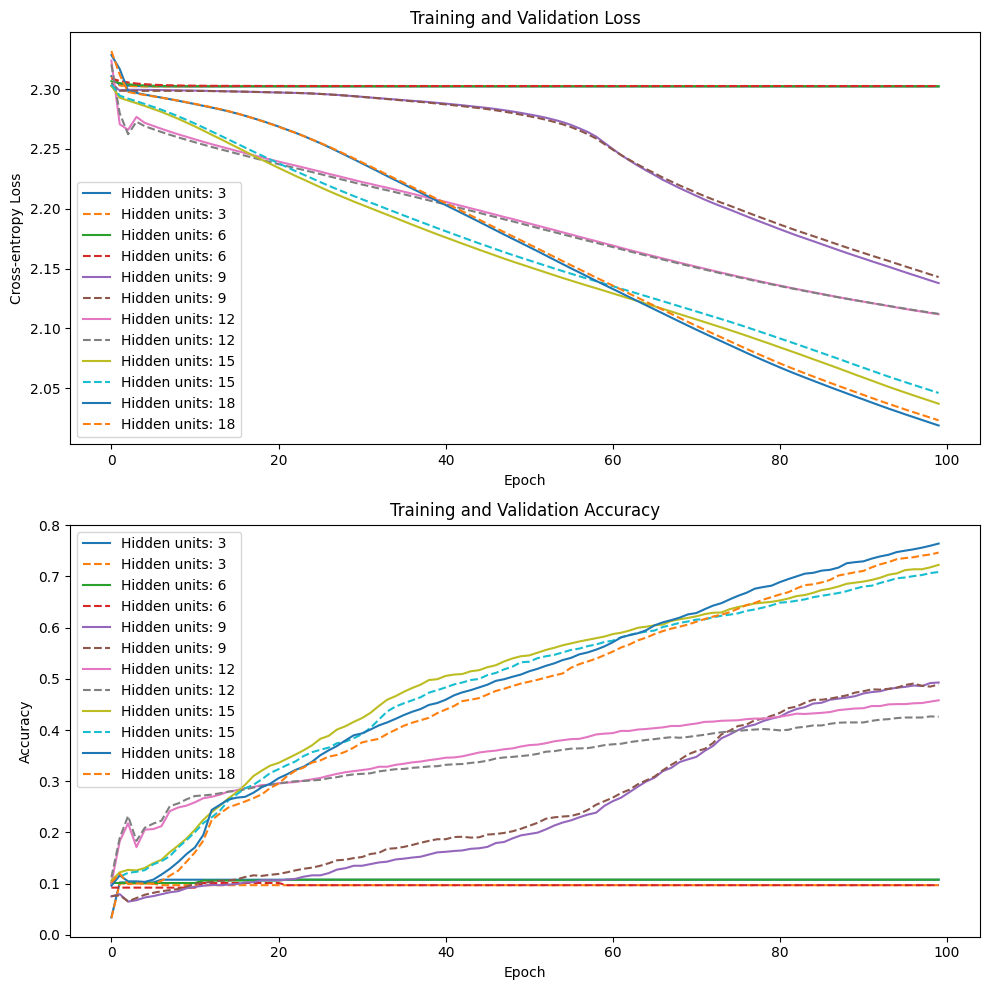

Best Hidden units: 18, Train Loss: 2.0404, Train Accuracy: 0.7314, Valid Loss: 2.0426, Valid Accuracy: 0.7154, Test Loss: 2.0513, Test Accuracy: 0.6969


In [5]:
# Train MLP with different number of hidden units
hidden_units = [3, 6, 9, 12, 15, 18]
num_epochs = 100
learning_rate = 0.2
train_losses = np.zeros((len(hidden_units), num_epochs))
valid_losses = np.zeros((len(hidden_units), num_epochs))
train_accuracies = np.zeros((len(hidden_units), num_epochs))
valid_accuracies = np.zeros((len(hidden_units), num_epochs))

for i, h in enumerate(hidden_units):
    mlp = MLP(train_X.shape[1], h, len(np.unique(train_y)))
    for epoch in range(num_epochs):
        # Train on training data
        train_scores, train_h = mlp.forward(train_X)
        mlp.backward(train_X, train_y, train_scores, train_h, learning_rate)
        train_loss, train_accuracy = mlp.evaluate(train_X, train_y)
        train_losses[i, epoch] = train_loss
        train_accuracies[i, epoch] = train_accuracy
        # Evaluate on validation data
        valid_loss, valid_accuracy = mlp.evaluate(valid_X, valid_y)
        valid_losses[i, epoch] = valid_loss
        valid_accuracies[i, epoch] = valid_accuracy
    print(f"Hidden units: {h}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

# Plot training and validation loss and accuracy curves
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, h in enumerate(hidden_units):
    axes[0].plot(range(num_epochs), train_losses[i], label=f"Hidden units: {h}")
    axes[0].plot(range(num_epochs), valid_losses[i], "--", label=f"Hidden units: {h}")
    axes[1].plot(range(num_epochs), train_accuracies[i], label=f"Hidden units: {h}")
    axes[1].plot(range(num_epochs), valid_accuracies[i], "--", label=f"Hidden units: {h}")

axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross-entropy Loss")
axes[0].legend()

axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

# Evaluate on test data using the best model
best_hidden_units = hidden_units[np.argmax(valid_accuracies[:, -1])]
mlp = MLP(train_X.shape[1], best_hidden_units, len(np.unique(train_y)))
for epoch in range(num_epochs):
    train_scores, train_h = mlp.forward(train_X)
    mlp.backward(train_X, train_y, train_scores, train_h, learning_rate)
train_loss, train_accuracy = mlp.evaluate(train_X, train_y)
valid_loss, valid_accuracy = mlp.evaluate(valid_X, valid_y)
test_loss, test_accuracy = mlp.evaluate(test_X, test_y)
print(f"Best Hidden units: {best_hidden_units}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


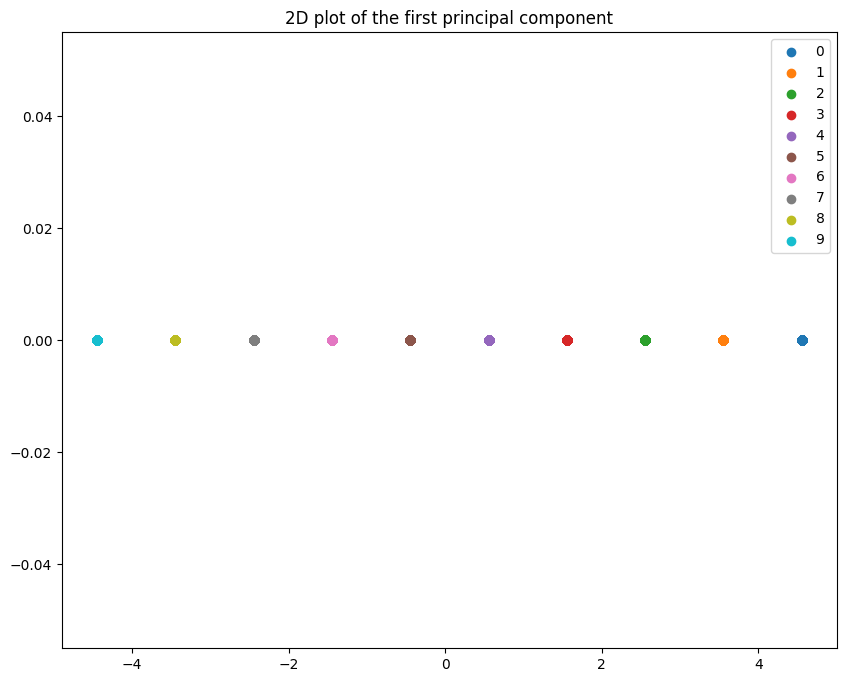

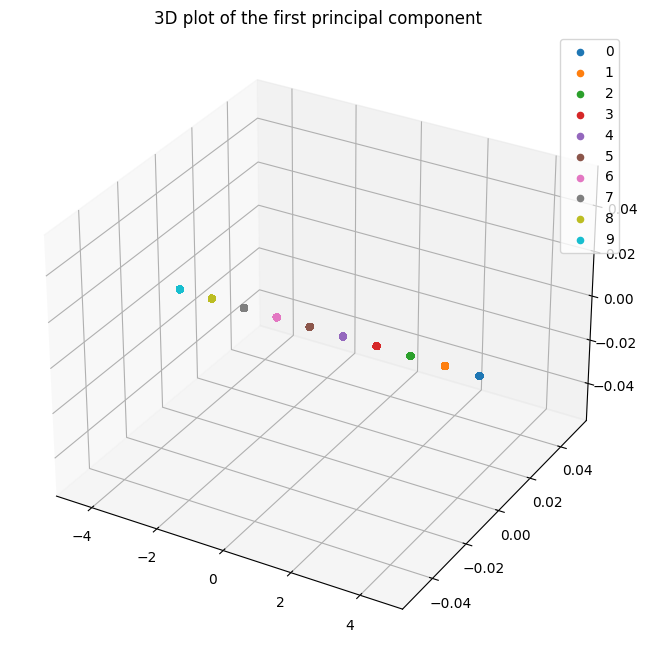

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

# Combine training and validation sets
X_train_val = np.concatenate((train_X, valid_X), axis=0)
y_train_val = np.concatenate((train_y, valid_y), axis=0)

# Train MLP with best number of hidden units
mlp = MLPClassifier(hidden_layer_sizes=best_hidden_units, activation='relu', solver='sgd', learning_rate_init=0.2, max_iter=1000, random_state=0)
mlp.fit(X_train_val, y_train_val)

hidden_units = mlp.predict(X_train_val)

# Get values from hidden units
hidden_units = np.expand_dims(hidden_units, axis=1)

pca = PCA(n_components=1)
pca.fit(hidden_units)
X_pca = pca.transform(hidden_units)

# 2D plot
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(X_pca[y_train_val == i, 0], np.zeros_like(X_pca[y_train_val == i, 0]), label=str(i))  # Set y-coordinate to 0 for all samples
plt.title('2D plot of the first principal component')
plt.legend()
plt.show()

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
for i in range(10):
    ax.scatter(X_pca[y_train_val == i, 0], np.zeros_like(X_pca[y_train_val == i, 0]), np.zeros_like(X_pca[y_train_val == i, 0]), label=str(i))  # Set y- and z-coordinates to 0 for all samples
plt.title('3D plot of the first principal component')
plt.legend()
plt.show()
